# Benchmark Results
This notebook visualizes the output from the different models on different classification problems

In [1]:
import collections
import glob
import itertools
import json
import os

import numpy as np
import pandas as pd
import plotnine
import svgutils.transform as sg
from svgutils.compose import SVG, Figure, Panel
from plotnine import *

## Binary Prediction

In [2]:
top_five_tissues = ['Blood', 'Breast', 'Stem_Cell', 'Cervix', 'Brain']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Breast'), ('Blood', 'Stem_Cell'), ('Blood', 'Cervix')]

In [3]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

180

In [4]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
    
    tissue1 = run_info[0]
    tissue2 = run_info[1]
    
    model_and_seed = run_info[2].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'three_layer_net')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'five_layer_net')

## Pairwise comparisons

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_binary.svg


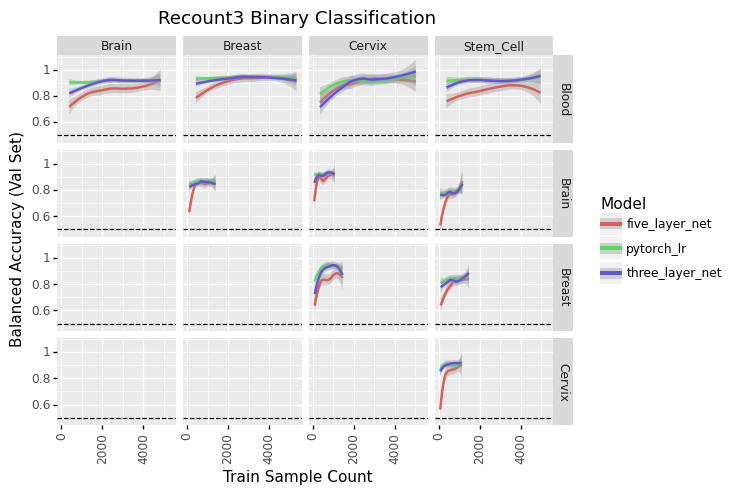

<ggplot: (8785545014189)>

In [5]:
plot_df = run_results[run_results['correction_method'] == 'unmodified']
plot_df = plot_df[plot_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()

plot += geom_hline(yintercept=.5, linetype='dashed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Binary Classification')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/recount_binary.svg')
plot

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_binary_signal_removed.svg


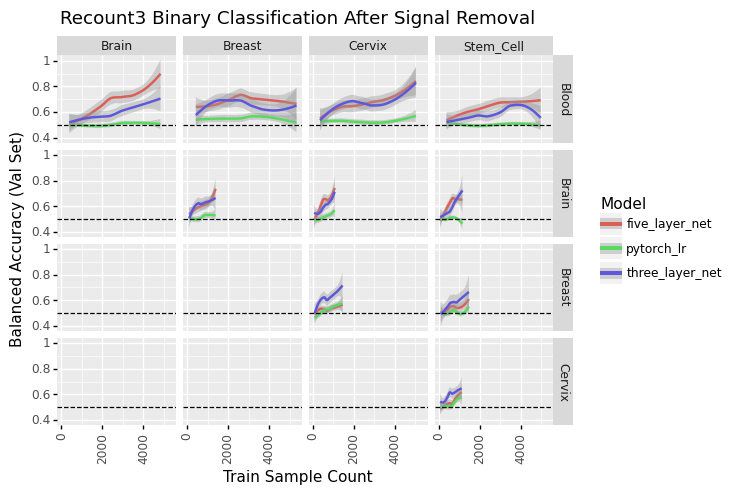

<ggplot: (8785545016773)>

In [6]:
plot_df = run_results[run_results['correction_method'] == 'signal_removed']
plot_df = plot_df[plot_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')


plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['tissue1', 'tissue2'], scales='fixed')
plot += ggtitle('Recount3 Binary Classification After Signal Removal')
plot += theme(axis_text_x=element_text(rotation=90, hjust=.25))
plot.save('../../figures/recount_binary_signal_removed.svg')
plot

### Combine figures

In [7]:
# You have to look at the xml content of the svgs to determine their width and height to get
# the new figure to be the correct size :(
fig = sg.SVGFigure("356pt", "969pt")

fig1 = sg.fromfile('../../figures/recount_binary.svg')
fig2 = sg.fromfile('../../figures/recount_binary_signal_removed.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot1.moveto(0, 0, )
plot2.moveto(425, 0, )

fig.append([plot1, plot2])

fig.save('../../figures/recount_binary_combined.svg')

## All Tissue Predictions

In [8]:
in_files = glob.glob('../../results/all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/all-tissue.pytorch_lr_2.tsv', '../../results/all-tissue.deep_net_1.tsv', '../../results/all-tissue.logistic_regression_2.tsv', '../../results/all-tissue.pytorch_lr_2_signal_removed.tsv', '../../results/all-tissue.deep_net_2_signal_removed.tsv']


In [9]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass.svg


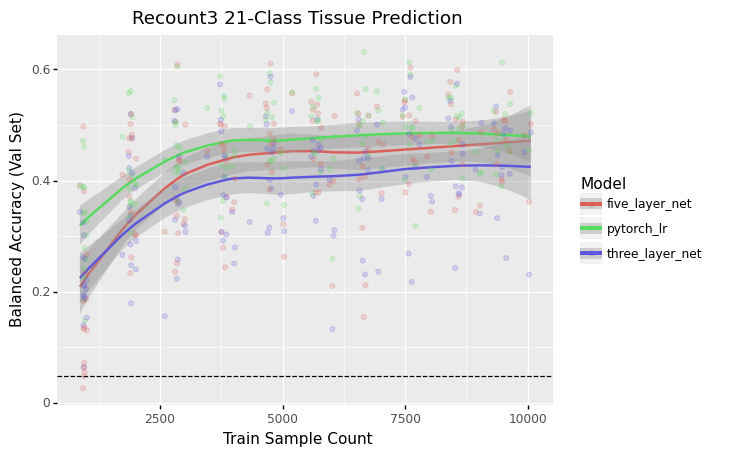

<ggplot: (8785502110697)>

In [10]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 

plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=1/21, linetype='dashed')
plot += ggtitle('Recount3 21-Class Tissue Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass.svg')
plot

### All tissue signal removed

In [11]:
in_files = glob.glob('../../results/all-tissue.*.tsv')
in_files = [f for f in in_files if 'signal_removed' in f]
print(in_files[:5])

['../../results/all-tissue.pytorch_lr_2_signal_removed.tsv', '../../results/all-tissue.deep_net_2_signal_removed.tsv', '../../results/all-tissue.deep_net_1_signal_removed.tsv', '../../results/all-tissue.pytorch_lr_1_signal_removed.tsv', '../../results/all-tissue.pytorch_supervised_2_signal_removed.tsv']


In [12]:
sr_tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-3])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-3]
        
    sr_tissue_metrics = pd.concat([sr_tissue_metrics, new_df])
    
sr_tissue_metrics['train_count'] = sr_tissue_metrics['train sample count']

sr_tissue_metrics['Model'] = sr_tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
sr_tissue_metrics['Model'] = sr_tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass_signal_removed.svg


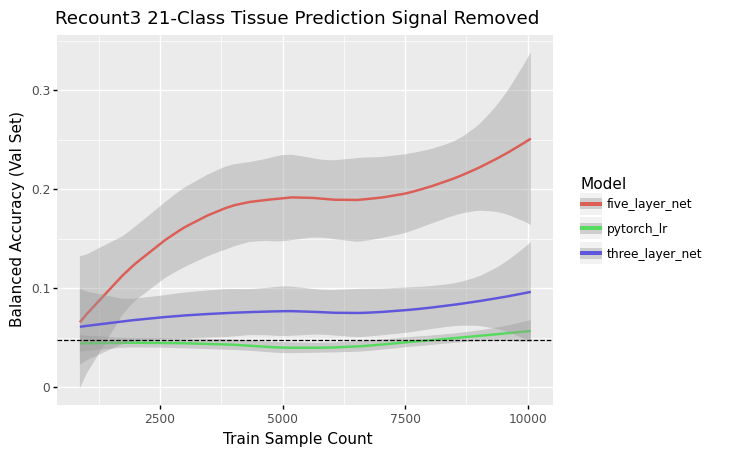

<ggplot: (8785544467989)>

In [13]:
plot_df = sr_tissue_metrics[sr_tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 

plot += geom_smooth()
plot += geom_hline(yintercept=1/21, linetype='dashed')
plot += ggtitle('Recount3 21-Class Tissue Prediction Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass_signal_removed.svg')
plot

### Combine recount multiclass figures

In [14]:
sr_tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.003072,0.047619,"DRP000622,SRP056840,SRP009474,SRP029592,DRP001...","SRR988504,SRR1002093,ERR752767,SRR1182626,SRR1...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",963,0.1,"13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,1...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,2,963
1,0.091268,0.077282,"SRP029592,SRP034606,SRP028705,SRP026690,SRP041...","SRR988504,SRR1002093,ERR752767,SRR1182626,SRR1...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1927,0.2,"11,11,11,11,11,11,5,12,12,12,11,11,11,11,11,7,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,2,1927
2,0.090391,0.076034,"SRP029592,SRP034606,SRP028705,SRP026690,SRP041...","SRR988504,SRR1002093,ERR752767,SRR1182626,SRR1...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",2890,0.3,"11,11,11,11,11,11,5,12,12,12,11,11,11,11,11,7,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,2,2890
3,0.014919,0.047619,"SRP029592,SRP034606,SRP028705,SRP026690,SRP041...","SRR988504,SRR1002093,ERR752767,SRR1182626,SRR1...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",3854,0.4,"5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,2,3854
4,0.036858,0.031309,"SRP029592,SRP034606,SRP028705,SRP026690,SRP041...","SRR988504,SRR1002093,ERR752767,SRR1182626,SRR1...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",4818,0.5,"4,4,4,4,4,4,4,12,12,12,4,4,4,4,4,4,4,4,4,4,4,4...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,2,4818
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.045141,0.050824,"SRP042119,SRP027508,SRP040117,SRP022052,SRP017...","SRR2052687,SRR1036103,SRR1002075,SRR1747250,ER...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",6019,0.6,"2,2,2,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3,3,3,3,2,2,...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,0,6019
46,0.007435,0.027584,"SRP042119,SRP027508,SRP040117,SRP022052,SRP017...","SRR2052687,SRR1036103,SRR1002075,SRR1747250,ER...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",7022,0.7,"8,8,8,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,0,7022
47,0.005842,0.047619,"SRP042119,SRP027508,SRP040117,SRP022052,SRP017...","SRR2052687,SRR1036103,SRR1002075,SRR1747250,ER...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",8025,0.8,"8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,0,8025
48,0.005842,0.047619,"SRP042119,SRP027508,SRP040117,SRP022052,SRP017...","SRR2052687,SRR1036103,SRR1002075,SRR1747250,ER...","SRR088863,SRR088864,SRR088865,SRR223507,SRR223...",9028,0.9,"8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,...","4,4,4,9,9,9,9,9,3,3,3,3,3,3,0,0,0,7,7,7,7,9,9,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,0,9028


In [15]:
sr_tissue_metrics = sr_tissue_metrics.loc[:,['balanced_accuracy', 'Model', 'train_count']]
sr_tissue_metrics['correction'] = 'Signal Removed'
tissue_metrics = tissue_metrics.loc[:,['balanced_accuracy', 'Model', 'train_count']]
tissue_metrics['correction'] = 'Full Signal'
combined_df = tissue_metrics.append(sr_tissue_metrics)
combined_df

,balanced_accuracy,Model,train_count,correction
0,0.147684,pytorch_lr,963,Full Signal
1,0.408157,pytorch_lr,1927,Full Signal
2,0.414586,pytorch_lr,2890,Full Signal
3,0.423669,pytorch_lr,3854,Full Signal
4,0.439294,pytorch_lr,4818,Full Signal
...,...,...,...,...
45,0.050824,pytorch_lr,6019,Signal Removed
46,0.027584,pytorch_lr,7022,Signal Removed
47,0.047619,pytorch_lr,8025,Signal Removed
48,0.047619,pytorch_lr,9028,Signal Removed


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass_combined.svg


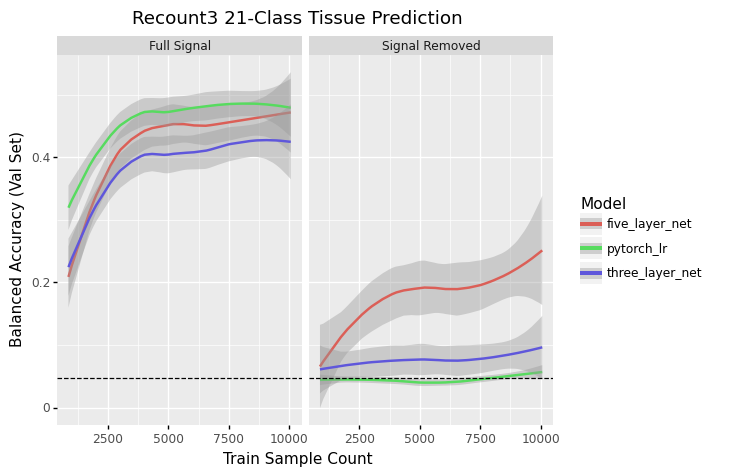

<ggplot: (8785500053117)>

In [16]:
plot_df = combined_df[combined_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 

plot += geom_smooth()
plot += geom_hline(yintercept=1/21, linetype='dashed')
plot += ggtitle('Recount3 21-Class Tissue Prediction')
plot += facet_wrap('correction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass_combined.svg')
plot

## All tissue sample split

In [17]:
in_files = glob.glob('../../results/all-tissue_sample-split*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/all-tissue_sample-split.deep_net_1.tsv', '../../results/all-tissue_sample-split.pytorch_lr_0.tsv', '../../results/all-tissue_sample-split.pytorch_supervised_0.tsv', '../../results/all-tissue_sample-split.deep_net_0.tsv', '../../results/all-tissue_sample-split.pytorch_supervised_2.tsv']


In [18]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue_sample-split.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
    new_df['split'] = 'sample'
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])

In [19]:
more_files = glob.glob('../../results/all-tissue.*')
more_files = [f for f in more_files if 'be_corrected' not in f]
print(more_files[:5])

['../../results/all-tissue.pytorch_lr_2.tsv', '../../results/all-tissue.deep_net_1.tsv', '../../results/all-tissue.logistic_regression_2.tsv', '../../results/all-tissue.pytorch_lr_2_signal_removed.tsv', '../../results/all-tissue.deep_net_2_signal_removed.tsv']


In [20]:
for path in more_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
    new_df['split'] = 'study'
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_multiclass_sample_split.svg


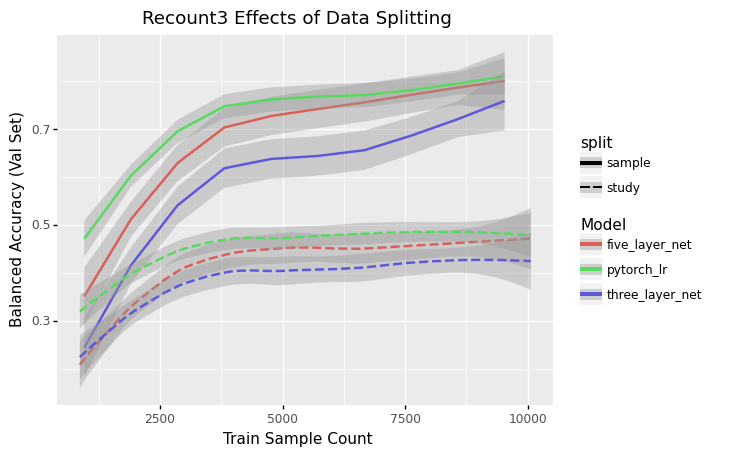

<ggplot: (8785500008469)>

In [21]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth(aes(linetype='split'))
plot += ggtitle('Recount3 Effects of Data Splitting')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_multiclass_sample_split.svg')
plot

## Pretraining

In [22]:
in_files = glob.glob('../../results/study-split.*.tsv')
print(in_files[:5])

['../../results/study-split.pytorch_supervised_2.tsv', '../../results/study-split.deep_net_2.tsv', '../../results/study-split.pytorch_lr_2.tsv', '../../results/study-split.deep_net_0.tsv', '../../results/study-split.pytorch_supervised_1.tsv']


In [23]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv')
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')
#tissue_metrics['Model'] = tissue_metrics['Model'] + '_' + tissue_metrics['is_pretrained']
tissue_metrics['pretrained'] = True
tissue_metrics.loc[tissue_metrics['is_pretrained'] == 'not_pretrained', 'pretrained'] = False
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,Model,seed,train_count,pretrained
0,0.468627,0.282689,"SRP010678,SRP014620,SRP003021,SRP011233,SRP010...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",478,0.1,pretrained,"11,11,11,11,11,11,6,4,4,4,11,11,11,11,11,3,3,3...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,478,True
1,0.312857,0.084397,"SRP010678,SRP014620,SRP003021,SRP011233,SRP010...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",478,0.1,not_pretrained,"0,0,0,0,0,0,6,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,478,False
2,0.503291,0.300654,"SRP010678,SRP014620,SRP035883,SRP003021,SRP011...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",957,0.2,pretrained,"11,11,11,11,11,5,5,4,4,4,6,6,4,4,4,3,3,3,3,3,6...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,957,True
3,0.424309,0.047619,"SRP010678,SRP014620,SRP035883,SRP003021,SRP011...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",957,0.2,not_pretrained,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,957,False
4,0.519087,0.283848,"SRP010678,SRP014620,SRP033569,SRP035883,SRP003...","SRR1191342,SRR1027603,ERR204879,SRR957901,SRR9...","SRR1513329,SRR1513330,SRR1513331,SRR1513332,SR...",1435,0.3,pretrained,"11,11,11,11,11,11,9,4,4,4,11,11,4,4,4,3,3,3,3,...","4,4,4,4,4,4,5,4,4,4,20,20,20,20,20,20,20,20,20...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,2,1435,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.134600,0.095473,"SRP042620,SRP015845,SRP059172,SRP028612,SRP035...","SRR357235,SRR521454,SRR1521364,SRR1521399,SRR5...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",4111,0.8,not_pretrained,"13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,1...","3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,1,4111,False
96,0.313143,0.340958,"SRP042620,SRP015845,SRP059172,SRP028612,SRP035...","SRR357235,SRR521454,SRR1521364,SRR1521399,SRR5...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",4625,0.9,pretrained,"16,16,16,16,16,16,16,16,16,16,16,16,16,13,13,1...","3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,1,4625,True
97,0.263658,0.104306,"SRP042620,SRP015845,SRP059172,SRP028612,SRP035...","SRR357235,SRR521454,SRR1521364,SRR1521399,SRR5...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",4625,0.9,not_pretrained,"13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,1...","3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,1,4625,False
98,0.499208,0.360101,"SRP042620,SRP015845,SRP026089,SRP059172,SRP028...","SRR357235,SRR521454,SRR1521364,SRR1521399,SRR5...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",5139,1.0,pretrained,"7,13,13,13,13,13,13,13,7,13,13,13,13,13,13,13,...","3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",pytorch_lr,1,5139,True


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/recount_pretraining.svg


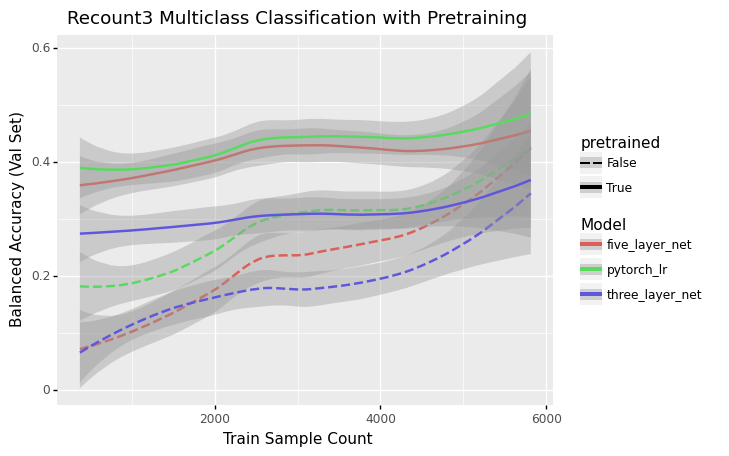

<ggplot: (8785500014157)>

In [24]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth(aes(linetype='pretrained'))
plot += ggtitle('Recount3 Multiclass Classification with Pretraining')
plot += scale_linetype_manual(['dashed', 'solid'])
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/recount_pretraining.svg')
plot

## Sex Prediction

### Study Level

In [25]:
in_files = glob.glob('../../results/study-split-sex-prediction.*.tsv')
print(in_files[:5])

['../../results/study-split-sex-prediction.pytorch_lr_1.tsv', '../../results/study-split-sex-prediction.pytorch_supervised_1.tsv', '../../results/study-split-sex-prediction.pytorch_supervised_0.tsv', '../../results/study-split-sex-prediction.pytorch_lr_2.tsv', '../../results/study-split-sex-prediction.deep_net_2.tsv']


In [26]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.757891,0.761315,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",1756,0.1,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,1756
1,0.820349,0.826195,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",3513,0.2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,3513
2,0.821189,0.816641,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",5270,0.3,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,5270
3,0.863499,0.860018,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",7027,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,7027
4,0.847213,0.849006,"ERP001458,SRP017262,SRP154566,SRP056612,SRP115...","SRR1296055,SRR1987677,ERR1806314,SRR4241424,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",8784,0.5,"0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",pytorch_lr,1,8784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.856948,0.857089,"SRP071758,SRP070710,SRP075396,SRP077046,SRP096...","ERR1991712,SRR5981882,SRR1282972,SRR3031922,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",11916,0.6,"0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,11916
46,0.770407,0.775045,"SRP071758,SRP070710,SRP075396,SRP077046,SRP096...","ERR1991712,SRR5981882,SRR1282972,SRR3031922,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",13902,0.7,"1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,13902
47,0.754573,0.763809,"SRP071758,SRP070710,SRP075396,SRP077046,SRP096...","ERR1991712,SRR5981882,SRR1282972,SRR3031922,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",15888,0.8,"0,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,15888
48,0.747748,0.751924,"SRP071758,SRP070710,SRP075396,SRP077046,SRP096...","ERR1991712,SRR5981882,SRR1282972,SRR3031922,SR...","SRR1017149,SRR1017150,SRR1017151,SRR1017152,SR...",17874,0.9,"1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,1,...","1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,...","{""female"": 0, ""male"": 1}",three_layer_net,2,17874


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction_studywise.svg


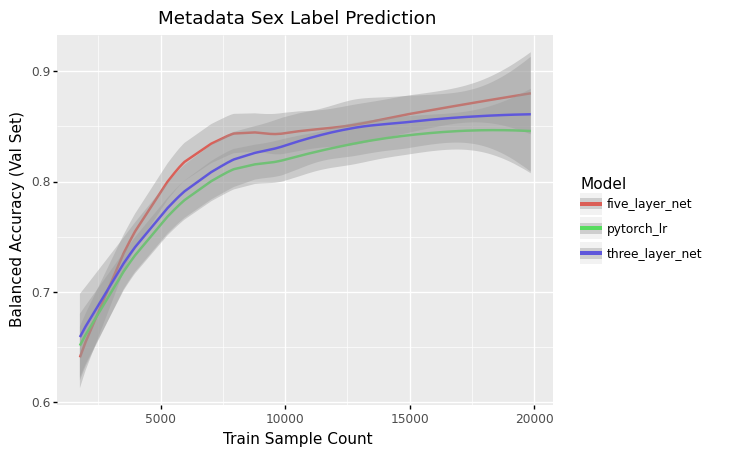

<ggplot: (8785500029589)>

In [27]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Metadata Sex Label Prediction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction_studywise.svg')
plot

### Study level signal removed

In [28]:
in_files = glob.glob('../../results/sex-prediction-signal-removed.*.tsv')
print(in_files[:5])

['../../results/sex-prediction-signal-removed.deep_net_1.tsv', '../../results/sex-prediction-signal-removed.pytorch_supervised_2.tsv', '../../results/sex-prediction-signal-removed.pytorch_lr_1.tsv', '../../results/sex-prediction-signal-removed.deep_net_0.tsv', '../../results/sex-prediction-signal-removed.pytorch_lr_2.tsv']


In [29]:
sr_tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sex-prediction-signal-removed.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    sr_tissue_metrics = pd.concat([sr_tissue_metrics, new_df])
    
sr_tissue_metrics['train_count'] = sr_tissue_metrics['train sample count']
sr_tissue_metrics['Model'] = sr_tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
sr_tissue_metrics['Model'] = sr_tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction_signal_removed.svg


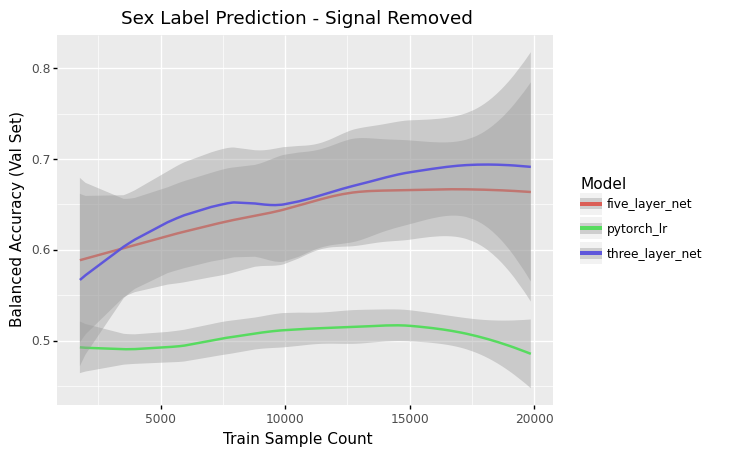

<ggplot: (8785499952109)>

In [30]:
plot_df = sr_tissue_metrics[sr_tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Sex Label Prediction - Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction_signal_removed.svg')
plot

### Combine plots

In [31]:
sr_tissue_metrics = sr_tissue_metrics.loc[:,['balanced_accuracy', 'Model', 'train_count']]
sr_tissue_metrics['correction'] = 'Signal Removed'
tissue_metrics = tissue_metrics.loc[:,['balanced_accuracy', 'Model', 'train_count']]
tissue_metrics['correction'] = 'Full Signal'
combined_df = tissue_metrics.append(sr_tissue_metrics)
combined_df

,balanced_accuracy,Model,train_count,correction
0,0.761315,pytorch_lr,1756,Full Signal
1,0.826195,pytorch_lr,3513,Full Signal
2,0.816641,pytorch_lr,5270,Full Signal
3,0.860018,pytorch_lr,7027,Full Signal
4,0.849006,pytorch_lr,8784,Full Signal
...,...,...,...,...
45,0.474182,five_layer_net,11916,Signal Removed
46,0.459796,five_layer_net,13902,Signal Removed
47,0.519185,five_layer_net,15888,Signal Removed
48,0.465082,five_layer_net,17874,Signal Removed


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sex_prediction.svg


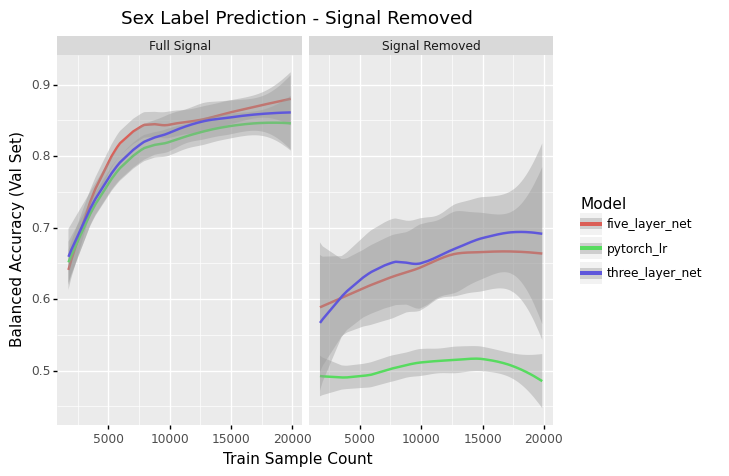

<ggplot: (8785499895965)>

In [32]:
plot_df = combined_df[combined_df['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('Sex Label Prediction - Signal Removed')
plot += facet_wrap('correction')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sex_prediction.svg')
plot

In [33]:
#create new SVG figure
fig = sg.SVGFigure("328pt", "940")

# load matpotlib-generated figures
fig1 = sg.fromfile('../../figures/sex_prediction_studywise.svg')
fig2 = sg.fromfile('../../figures/sex_prediction_signal_removed.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()

plot1.moveto(0, 0,)
plot2.moveto(415, 0,)

fig.append([plot1, plot2,])

fig.save('../../figures/sex_prediction.svg')

## GTEx All Tissues

In [34]:
in_files = glob.glob('../../results/gtex-all-tissue.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/gtex-all-tissue.deep_net_1.tsv', '../../results/gtex-all-tissue.deep_net_0.tsv', '../../results/gtex-all-tissue.pytorch_lr_0.tsv', '../../results/gtex-all-tissue.pytorch_supervised_1.tsv', '../../results/gtex-all-tissue.deep_net_2.tsv']


In [35]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('all-tissue.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_multiclass.svg


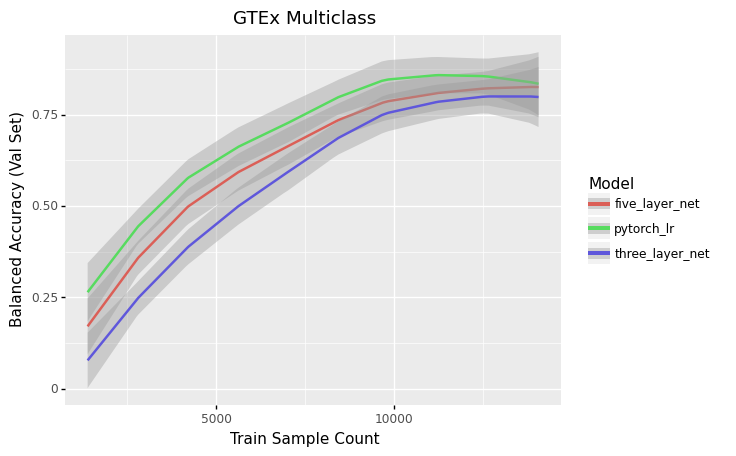

<ggplot: (8785499898313)>

In [36]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
#plot += geom_point(alpha=.2)
plot += ggtitle('GTEx Multiclass')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_multiclass.svg')
plot

In [37]:
in_files = glob.glob('../../results/gtex-all-tissue-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/gtex-all-tissue-signal-removed.pytorch_lr_0.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_supervised_0.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_supervised_1.tsv', '../../results/gtex-all-tissue-signal-removed.pytorch_supervised_2.tsv', '../../results/gtex-all-tissue-signal-removed.deep_net_2.tsv']


In [38]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('gtex-all-tissue-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_multiclass_signal_removed.svg


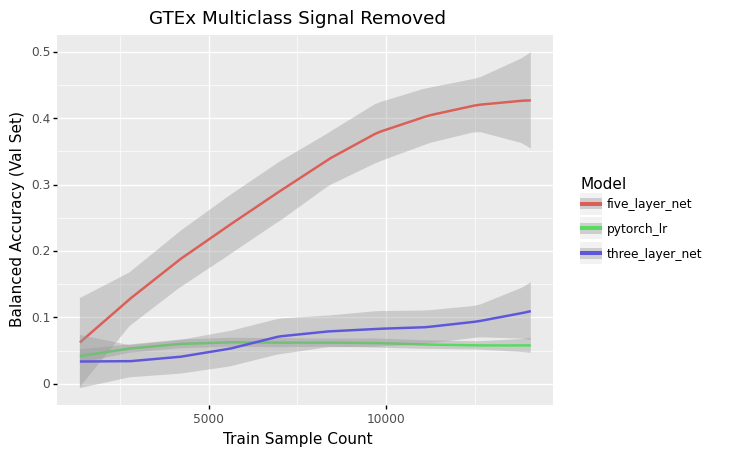

<ggplot: (8785502819605)>

In [39]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += ggtitle('GTEx Multiclass Signal Removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_multiclass_signal_removed.svg')
plot

## Binary Predictions

In [40]:
top_five_tissues = ['Blood', 'Brain', 'Skin', 'Esophagus', 'Blood_Vessel']

combo_iterator = itertools.combinations(top_five_tissues, 2)
tissue_pairs = [pair for pair in combo_iterator]
tissue_pairs[:3]

[('Blood', 'Brain'), ('Blood', 'Skin'), ('Blood', 'Esophagus')]

In [41]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/gtex.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

90

In [42]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
        
    tissue1 = run_info[1]
    tissue2 = run_info[2]
    
    model_and_seed = run_info[3].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
    
    correction_method = 'unmodified'
    if 'signal_removed' in path:
        if 'sample_level' in path:
            correction_method = 'signal_removed_sample_level'
        else:
            correction_method = 'signal_removed'
    elif 'study_corrected' in path:
        correction_method = 'study_corrected'
    elif 'split_signal' in path:
        correction_method = 'split_signal'
    
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['correction_method'] = correction_method
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'three_layer_net')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_pairwise.svg


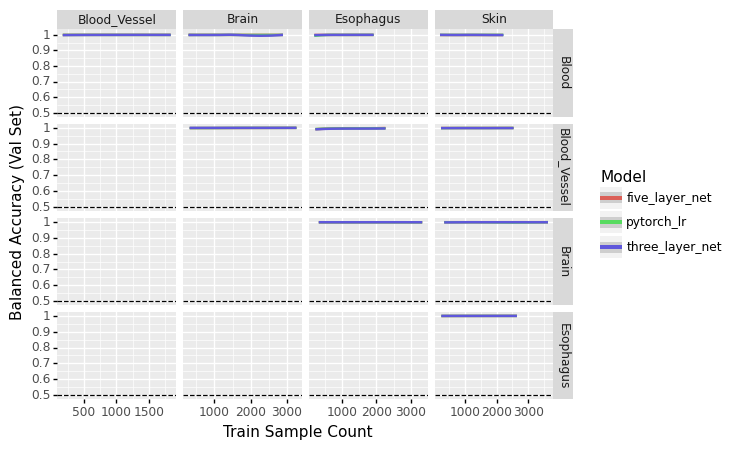

<ggplot: (8785502534837)>

In [43]:
plot_df = run_results[run_results['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot_df = plot_df[plot_df['correction_method'] == 'unmodified']
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'], scales='free')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_pairwise.svg')
plot

In [44]:
in_files = []
for pair in tissue_pairs:
    in_files.extend(glob.glob('../../results/gtex-signal-removed.{}.{}.*.tsv'.format(pair[0], pair[1])))
len(in_files)

90

In [45]:
run_results = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    run_info = os.path.basename(path).split('.')
        
    tissue1 = run_info[1]
    tissue2 = run_info[2]
    
    model_and_seed = run_info[3].split('-')[0]
    seed = model_and_seed.split('_')[-1]
    model = '_'.join(model_and_seed.split('_')[:-1])
        
    new_df['Model'] = model
    new_df['seed'] = seed
    if tissue1 < tissue2:
        new_df['tissue1'] = tissue1
        new_df['tissue2'] = tissue2
    else:
        new_df['tissue1'] = tissue2
        new_df['tissue2'] = tissue1
    new_df['pair'] = new_df['tissue1'] + '-' + new_df['tissue2'] 
    
    run_results = pd.concat([run_results, new_df])
    
run_results['train_count'] = run_results['train sample count']
run_results['Model'] = run_results['Model'].str.replace('pytorch_supervised', 'three_layer_net')
run_results['Model'] = run_results['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/gtex_pairwise_signal_removed.svg


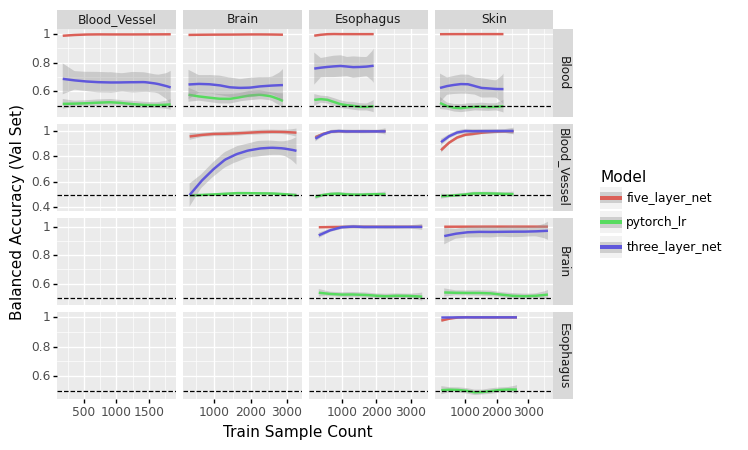

<ggplot: (8785502160205)>

In [46]:
plot_df = run_results[run_results['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += facet_grid(['tissue1', 'tissue2'], scales='free')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/gtex_pairwise_signal_removed.svg')
plot

### Combine GTEx

In [47]:
#create new SVG figure
fig = sg.SVGFigure("16cm", "16cm")

# load matpotlib-generated figures
fig1 = sg.fromfile('../../figures/gtex_multiclass.svg')
fig2 = sg.fromfile('../../figures/gtex_multiclass_signal_removed.svg')
fig3 = sg.fromfile('../../figures/gtex_pairwise.svg')
fig4 = sg.fromfile('../../figures/gtex_pairwise_signal_removed.svg')

plot1 = fig1.getroot()
plot3 = fig2.getroot()
plot2 = fig3.getroot()
plot4 = fig4.getroot()

plot1.moveto(0, 0, scale_x=.5, scale_y=.5)
plot2.moveto(0, 162, scale_x=.5, scale_y=.5)
plot3.moveto(210, 0, scale_x=.5, scale_y=.5)
plot4.moveto(210, 162, scale_x=.5, scale_y=.5)

fig.append([plot1, plot2, plot3, plot4])

fig.save('../../figures/gtex_combined.svg')

## Simulated data 

In [48]:
in_files = glob.glob('../../results/sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/sim-data.deep_net_2.tsv', '../../results/sim-data.pytorch_supervised_0.tsv', '../../results/sim-data.deep_net_1.tsv', '../../results/sim-data.pytorch_lr_0.tsv', '../../results/sim-data.pytorch_supervised_1.tsv']


In [49]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sim_data.svg


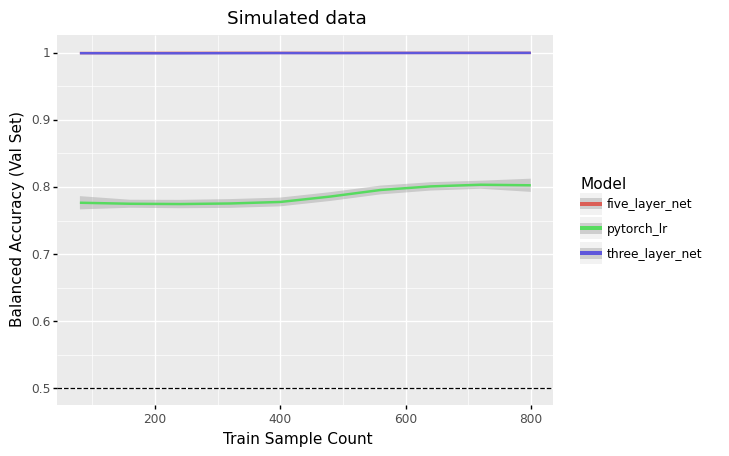

<ggplot: (8785502626361)>

In [50]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model')) 
plot += geom_smooth()
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated data')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sim_data.svg')
plot

In [51]:
in_files = glob.glob('../../results/sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/sim-data-signal-removed.pytorch_supervised_1.tsv', '../../results/sim-data-signal-removed.pytorch_lr_2.tsv', '../../results/sim-data-signal-removed.pytorch_supervised_2.tsv', '../../results/sim-data-signal-removed.pytorch_supervised_0.tsv', '../../results/sim-data-signal-removed.deep_net_1.tsv']


In [52]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/sim_data_signal_removed.svg


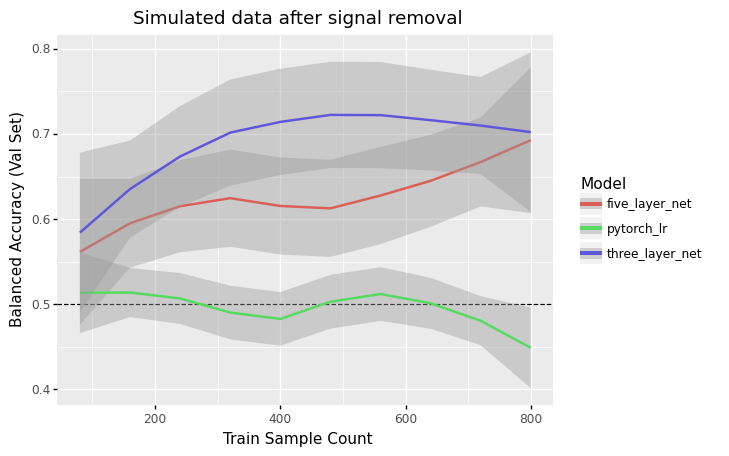

<ggplot: (8785500136565)>

In [53]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data after signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/sim_data_signal_removed.svg')
plot

In [54]:
in_files = glob.glob('../../results/no-signal-sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data.deep_net_0.tsv', '../../results/no-signal-sim-data.pytorch_supervised_2.tsv', '../../results/no-signal-sim-data.pytorch_supervised_0.tsv', '../../results/no-signal-sim-data.deep_net_2.tsv', '../../results/no-signal-sim-data.pytorch_lr_2.tsv']


In [55]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim.svg


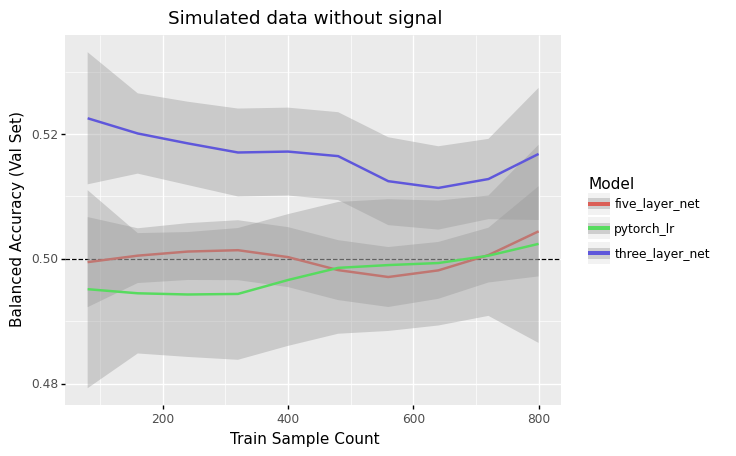

<ggplot: (8785499613581)>

In [56]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data without signal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim.svg')
plot

In [57]:
in_files = glob.glob('../../results/no-signal-sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data-signal-removed.pytorch_lr_1.tsv', '../../results/no-signal-sim-data-signal-removed.pytorch_lr_0.tsv', '../../results/no-signal-sim-data-signal-removed.deep_net_1.tsv', '../../results/no-signal-sim-data-signal-removed.deep_net_0.tsv', '../../results/no-signal-sim-data-signal-removed.deep_net_2.tsv']


In [58]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1]) 
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim_signal_removed.svg


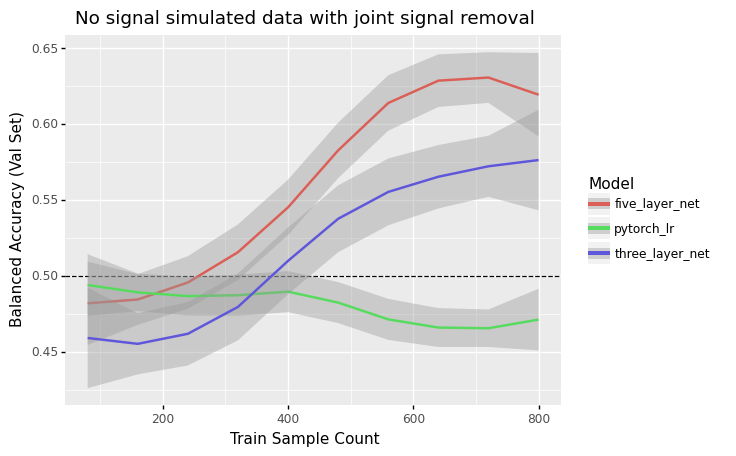

<ggplot: (8785499702857)>

In [59]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('No signal simulated data with joint signal removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim_signal_removed.svg')
plot

In [60]:
in_files = glob.glob('../../results/no-signal-sim-data-split-signal.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/no-signal-sim-data-split-signal.pytorch_lr_1.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_supervised_2.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_lr_0.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_supervised_0.tsv', '../../results/no-signal-sim-data-split-signal.pytorch_supervised_1.tsv']


In [61]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-split-signal.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/no_signal_sim_split_signal.svg


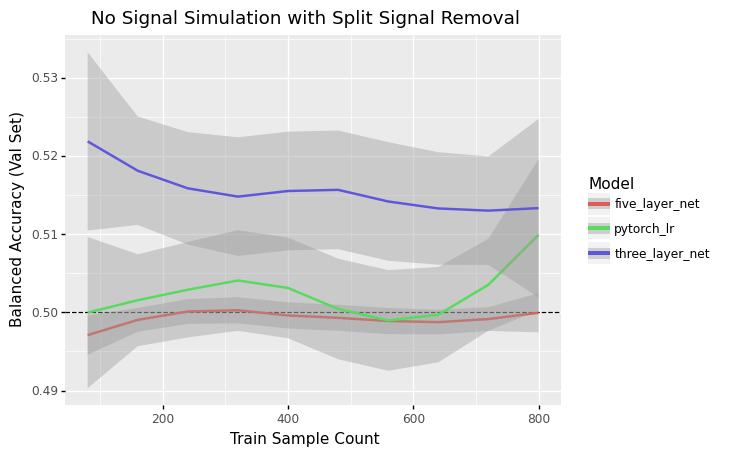

<ggplot: (8785499890721)>

In [62]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('No Signal Simulation with Split Signal Removal')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/no_signal_sim_split_signal.svg')
plot

## Linear signal only simulation

In [63]:
in_files = glob.glob('../../results/linear-sim-data.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/linear-sim-data.pytorch_lr_2.tsv', '../../results/linear-sim-data.pytorch_supervised_0.tsv', '../../results/linear-sim-data.pytorch_lr_1.tsv', '../../results/linear-sim-data.pytorch_supervised_1.tsv', '../../results/linear-sim-data.pytorch_lr_0.tsv']


In [64]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('linear-sim-data.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/linear_sim.svg


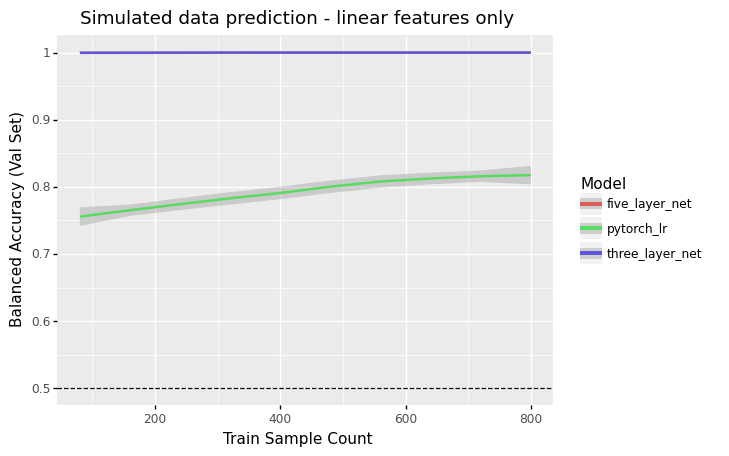

<ggplot: (8785499613493)>

In [65]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data prediction - linear features only')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/linear_sim.svg')
plot

In [66]:
in_files = glob.glob('../../results/linear-sim-data-signal-removed.*.tsv')
in_files = [f for f in in_files if 'be_corrected' not in f]
print(in_files[:5])

['../../results/linear-sim-data-signal-removed.deep_net_0.tsv', '../../results/linear-sim-data-signal-removed.deep_net_1.tsv', '../../results/linear-sim-data-signal-removed.deep_net_2.tsv', '../../results/linear-sim-data-signal-removed.pytorch_lr_0.tsv', '../../results/linear-sim-data-signal-removed.pytorch_lr_1.tsv']


In [67]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')
tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,val_predictions,val_true_labels,val_encoders,Model,seed,train_count
0,0.480,0.498990,"sample_356_study,sample_403_study,sample_13_st...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",80,0.1,"0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,1,1,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,0,80
1,0.450,0.479798,"sample_770_study,sample_170_study,sample_29_st...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",160,0.2,"0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,0,160
2,0.545,0.497475,"sample_770_study,sample_23_study,sample_170_st...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",240,0.3,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,0,240
3,0.435,0.482323,"sample_781_study,sample_178_study,sample_894_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",320,0.4,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,0,320
4,0.560,0.528283,"sample_781_study,sample_178_study,sample_894_s...","sample_489,sample_561,sample_503,sample_192,sa...","sample_1,sample_3,sample_4,sample_8,sample_12,...",400,0.5,"1,0,0,1,0,0,0,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",five_layer_net,0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.495,0.500000,"sample_282_study,sample_321_study,sample_608_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",480,0.6,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,0,480
46,0.505,0.500000,"sample_282_study,sample_321_study,sample_608_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",560,0.7,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,0,560
47,0.505,0.500000,"sample_282_study,sample_321_study,sample_608_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",640,0.8,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,0,640
48,0.495,0.500000,"sample_282_study,sample_321_study,sample_608_s...","sample_544,sample_490,sample_588,sample_207,sa...","sample_9,sample_13,sample_14,sample_22,sample_...",720,0.9,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","{""blue"": 0, ""red"": 1}",three_layer_net,0,720


/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/linear_sim_signal_removed.svg


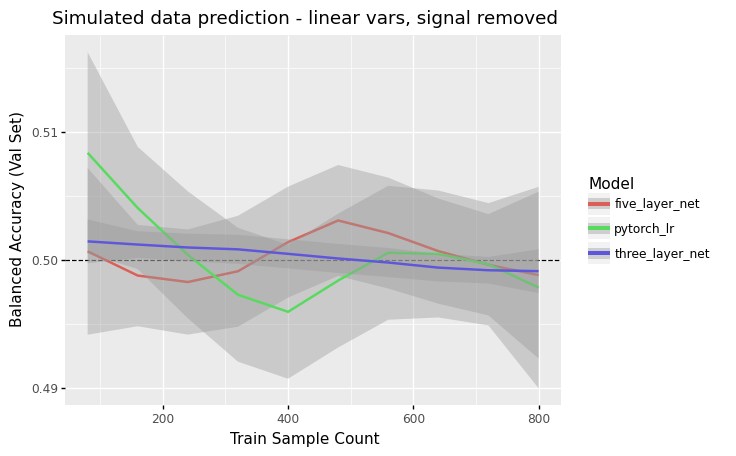

<ggplot: (8785500086849)>

In [68]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated data prediction - linear vars, signal removed')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot.save('../../figures/linear_sim_signal_removed.svg')
plot

### Combined Sim Figure

In [69]:
in_files = glob.glob('../../results/linear-sim*.tsv')
in_files.extend(glob.glob('../../results/no-signal-sim*.tsv'))
in_files.extend(glob.glob('../../results/sim-data*.tsv'))

In [70]:
tissue_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    if 'linear-sim-data-signal-removed.' in path:
        model_info = path.strip('.tsv').split('linear-sim-data-signal-removed.')[-1]
        new_df['correction'] = 'Signal Removed'
        new_df['simulation'] = 'Linear Sim'
    elif 'linear-sim-data.' in path:
        model_info = path.strip('.tsv').split('linear-sim-data.')[-1]
        new_df['correction'] = 'Full Signal'
        new_df['simulation'] = 'Linear Sim'
    elif '/sim-data.' in path:
        model_info = path.strip('.tsv').split('sim-data.')[-1]
        new_df['correction'] = 'Full Signal'
        new_df['simulation'] = 'Nonlinear Sim'
    elif '/sim-data-signal-removed.' in path:
        model_info = path.strip('.tsv').split('sim-data-signal-removed.')[-1]
        new_df['correction'] = 'Signal Removed'
        new_df['simulation'] = 'Nonlinear Sim'
    elif 'no-signal-sim-data.' in path:
        model_info = path.strip('.tsv').split('no-signal-sim-data.')[-1]
        new_df['correction'] = 'Full Signal'
        new_df['simulation'] = 'Random Sim'
    elif 'no-signal-sim-data-split-signal.' in path:
        model_info = path.strip('.tsv').split('no-signal-sim-data-split-signal.')[-1]
        new_df['correction'] = 'Signal Removed'
        new_df['simulation'] = 'Random Sim'
    else:
        continue
    model_info = model_info.split('_')    
    supervised_model = '_'.join(model_info[:-1])
             
    new_df['Model'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']

tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('pytorch_supervised', 'three_layer_net')
tissue_metrics['Model'] = tissue_metrics['Model'].str.replace('deep_net', 'five_layer_net')

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../figures/simulated_data_combined.svg


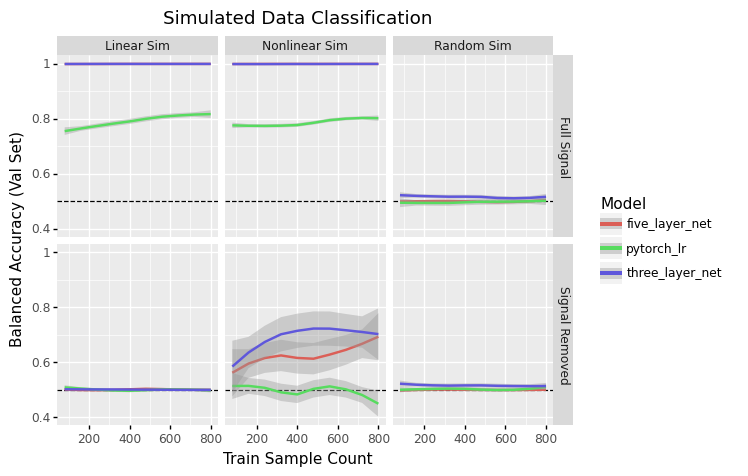

<ggplot: (8785499702837)>

In [71]:
plot_df = tissue_metrics[tissue_metrics['Model'].isin(['three_layer_net', 'five_layer_net', 'pytorch_lr'])]
plot = ggplot(plot_df, aes(x='train_count', y='balanced_accuracy', color='Model'))
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += geom_smooth()
plot += ggtitle('Simulated Data Classification')
plot += xlab('Train Sample Count')
plot += ylab('Balanced Accuracy (Val Set)')
plot += facet_grid(['correction', 'simulation'], scales='fixed')
plot.save('../../figures/simulated_data_combined.svg')
plot